In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, transpile
from qiskit.circuit import Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit_experiments.database_service import DbExperimentDataV1 as DbExperimentData

from calibrations import LinearizedCR, PulseEfficientCR, cx_circuit, MeasurementErrorMitigation
from model_circuits import single_step_no_opt, single_step, two_steps
from dynamics import plot_counts_with_curve

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibmq_jakarta')
provider_icepp = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='q-comp-training')
backend_icepp = provider_icepp.get_backend('ibmq_jakarta')

In [3]:
crs_linear = {
    (0, 1): LinearizedCR(backend, (1, 3)),
    (1, 2): LinearizedCR(backend, (3, 5)),
    (2, 3): LinearizedCR(backend, (5, 6))
}
crs_pe = {
    (0, 1): PulseEfficientCR(backend, (1, 3)),
    (1, 2): PulseEfficientCR(backend, (3, 5)),
    (2, 3): PulseEfficientCR(backend, (5, 6))
}
cxs = {
    (0, 1): cx_circuit(backend, 1, 3),
    (1, 0): cx_circuit(backend, 3, 1)
}
mem = MeasurementErrorMitigation(backend, [1, 3, 5, 6])

In [4]:
crs_linear[(0, 1)].load_calibration('58a018c8-1029-4bbf-9ad1-a16e57220444')
crs_linear[(1, 2)].load_calibration('d95780a6-120a-4df6-a63f-1049ee3b53bc')
crs_linear[(2, 3)].load_calibration('b8648948-fb0a-408a-bdf8-c2a2a99684b7')

mem.load_matrix('06530479-b302-4bab-92f9-2fa8229e99f9')

In [5]:
nsites = 4

J = 1. # Hamiltonian J parameter
mu = 0.5 # Hamiltonian mu parameter

M = 8 # number of Trotter steps
omegadt = 0.2 # Trotter step size

## Forward steps with LinearizedCR

In [6]:
single_step_circuit = single_step(J, mu, omegadt, crs=crs_linear, cxs=cxs)
two_step_circuit = two_steps(J, mu, omegadt, crs=crs_linear, cxs=cxs)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep // 2):
        circuit.compose(two_step_circuit, inplace=True)
    if nrep % 2 == 1:
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[1, 3, 5, 6], optimization_level=1)
circuits *= backend.configuration().max_experiments // M

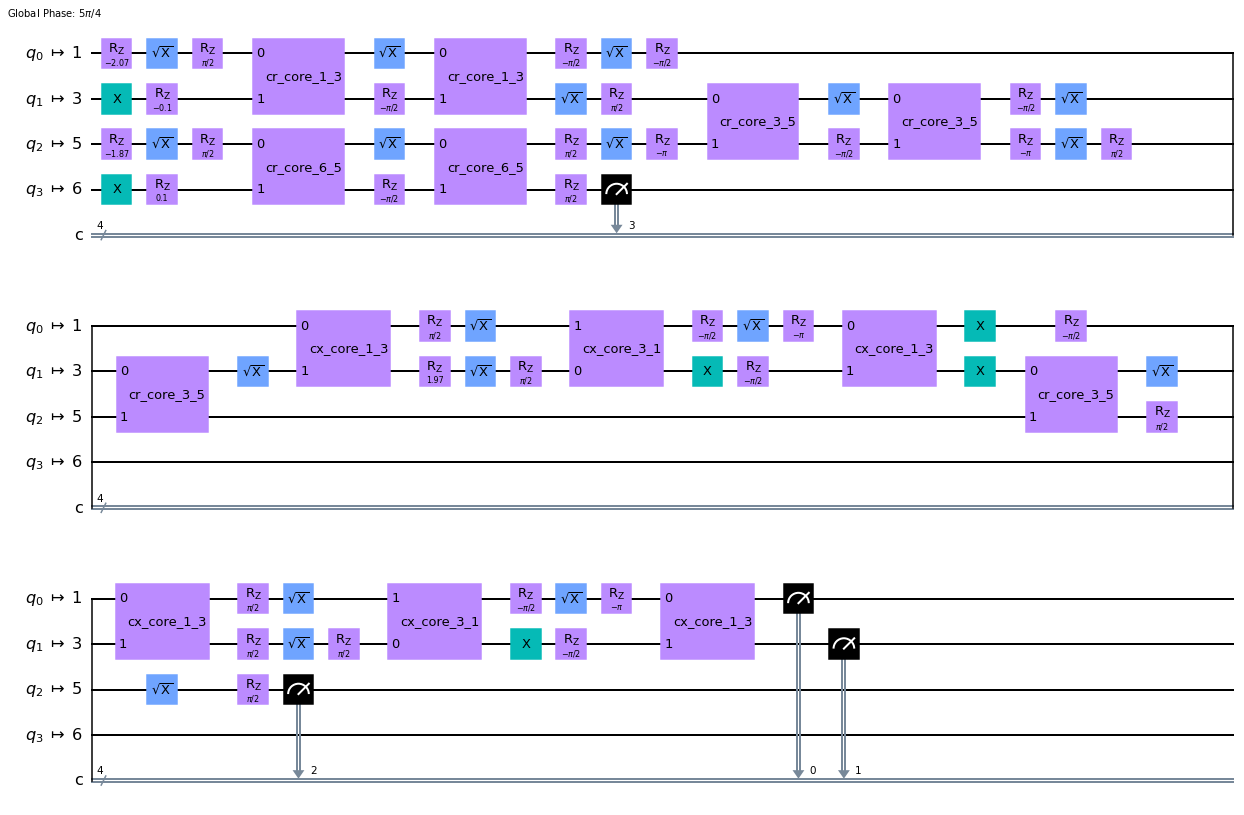

In [7]:
circuits[0].draw('mpl', idle_wires=False)

In [8]:
#job = backend.run(circuits, shots=8192)
#print(job.job_id())
#job_monitor(job)
job = backend.retrieve_job('6161bdadc978664b30093020')

{'0000': 1468.31867240148, '0001': 3876.82879077874, '0010': 40498.062674026965, '0011': 2120.0520446707296, '0100': 929.752518462911, '0101': 554.0574657478925, '0110': 5381.305670418321, '0111': 325.6555120397575, '1000': 20725.23779483526, '1001': 29129.704502782846, '1010': 313360.72183588566, '1011': 16842.392156645517, '1100': 16455.305908211496, '1101': 40119.94185876322, '1110': 403830.3308826023, '1111': 21886.33171172684}
[  1510   3982  40562   2092    976    557   5480    312  20533  29169
 312554  17037  16531  40230 404074  21904]
[1.95131866e-31 2.10557890e-01 3.07954030e-01 4.05329445e-01
 4.59505024e-01 4.35663730e-01 4.43908136e-01 4.21939417e-01
 4.02099237e-01]
[[0.         0.0001896  0.00031314 0.00024184 0.00023182 0.00030241
  0.00023759 0.00025624 0.0002454 ]
 [0.         0.00019896 0.0001964  0.00026824 0.00031395 0.00020658
  0.00022862 0.00026882 0.00026468]]


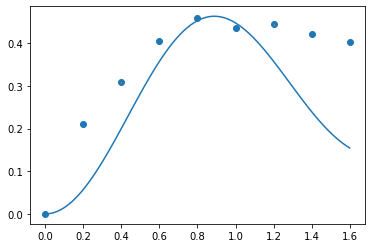

In [9]:
raw_counts = job.result().get_counts()
counts = raw_counts[:M]
for iexp, cdict in enumerate(raw_counts[M:]):
    ic = iexp % M
    for key, value in cdict.items():
        try:
            counts[ic][key] += value
        except KeyError:
            counts[ic][key] = value

counts = mem.apply(counts)

plot_counts_with_curve(counts, nsites, J, mu, omegadt, M)

In [14]:
from qiskit import Aer
from qiskit.visualization import plot_histogram
qasm = Aer.get_backend('qasm_simulator')
circuit = QuantumCircuit(nsites, nsites)
circuit.x(1)
circuit.x(3)
circuit.compose(single_step(J, mu, omegadt), inplace=True)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
counts = qasm.run(circuit, shots=100000).result().get_counts()
print(counts)

{'0011': 6, '0101': 164, '0110': 3808, '1010': 88638, '1001': 3711, '1100': 3673}


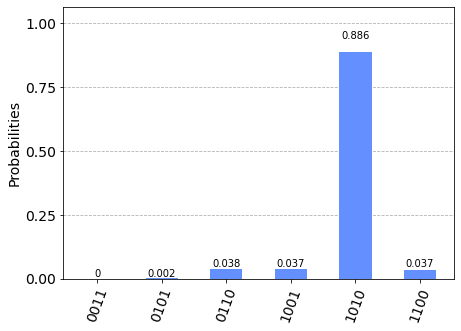

In [15]:
plot_histogram(counts)

## Forward steps with Pulse-Efficient CR

In [ ]:
backend = backend_icepp

In [ ]:
single_step_circuit = single_step(J, mu, omegadt, crs=crs_pe, cxs=cxs)
two_step_circuit = two_steps(J, mu, omegadt, crs=crs_pe, cxs=cxs)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep // 2):
        circuit.compose(two_step_circuit, inplace=True)
    if nrep % 2 == 1:
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[1, 3, 5, 6], optimization_level=1)
circuits *= backend.configuration().max_experiments // M

In [ ]:
#job = backend.run(circuits, shots=8192)
#print(job.job_id())
#job_monitor(job)
job = backend.retrieve_job('6161cc37ed29dd246fc6826e')

In [ ]:
raw_counts = job.result().get_counts()
counts = raw_counts[:M]
for iexp, cdict in enumerate(raw_counts[M:]):
    ic = iexp % M
    for key, value in cdict.items():
        try:
            counts[ic][key] += value
        except KeyError:
            counts[ic][key] = value

counts = mem.apply(counts)

plot_counts_with_curve(counts, nsites, J, mu, omegadt, M)

## Forward with CNOT-based implementation (optimization level 3)

In [ ]:
single_step_circuit = single_step_no_opt(J, mu, omegadt)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep):
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[1, 3, 5, 6], optimization_level=3)
circuits *= backend.configuration().max_experiments // M

In [ ]:
#job = backend.run(circuits, shots=8192)
#print(job.job_id())
#job_monitor(job)
job = backend.retrieve_job('616213fcc97866743e0931d4')

In [ ]:
raw_counts = job.result().get_counts()
counts = raw_counts[:M]
for iexp, cdict in enumerate(raw_counts[M:]):
    ic = iexp % M
    for key, value in cdict.items():
        try:
            counts[ic][key] += value
        except KeyError:
            counts[ic][key] = value

counts = mem.apply(counts)

plot_counts_with_curve(counts, nsites, J, mu, omegadt, M)

In [ ]:
backend.configuration().max_experiments // M

In [ ]:
circuits[1].draw('mpl', idle_wires=False)